In [1]:
from adios2toolspy import SuperCell, Particles, Fields
from h5toolspy import H5Processor
from picplot import fieldGrid, histGrid
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

%matplotlib inline 
plt.rcParams['figure.figsize'] = [16, 8]

## Full Grid B

## Pick Domain
y: point on x-axis, z: point on y-axis

Loading hx_fc from File: tfd.029000.xdmf


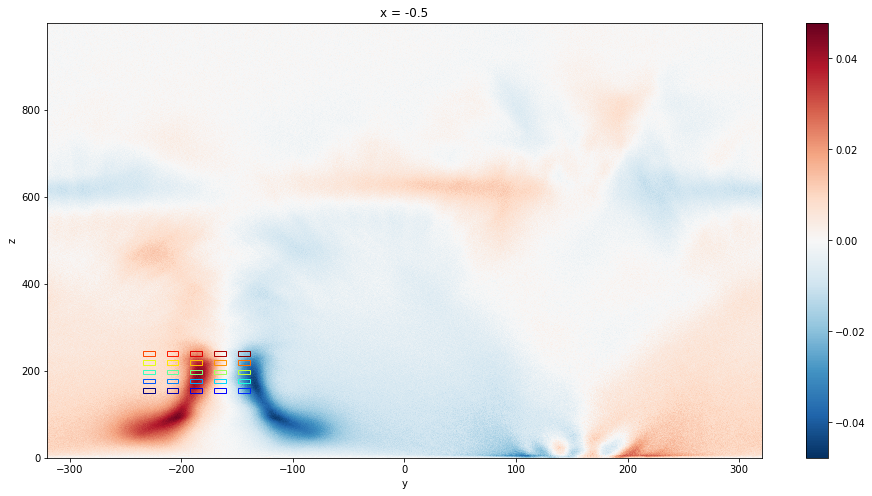

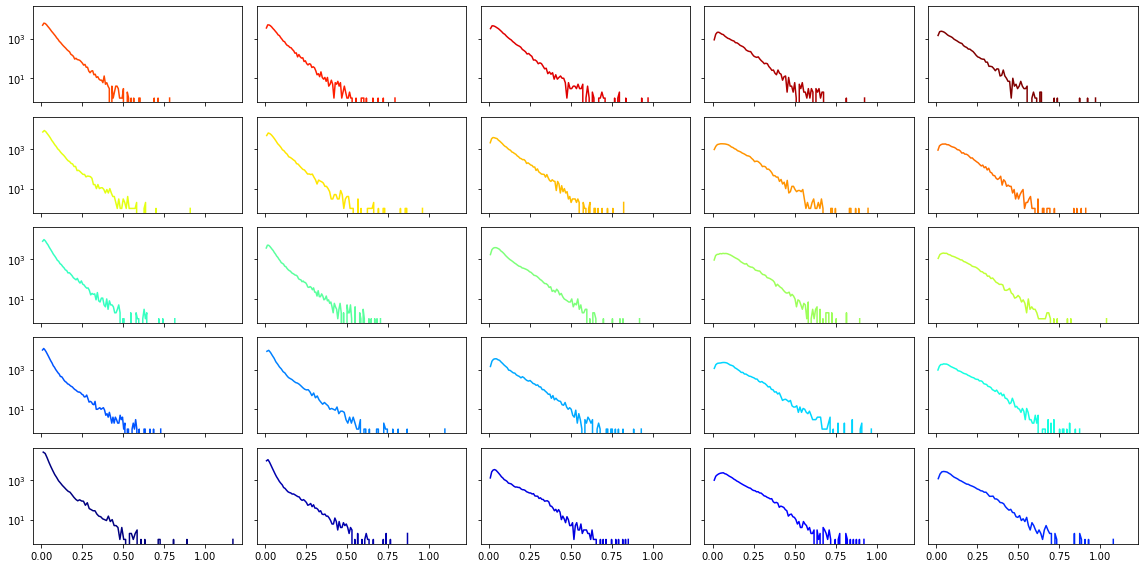

In [2]:
#root = '/gpfs/alpine/proj-shared/fus137/johnd/flatfoil-summit_10-21/run2Dratio01/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/flatfoil-summit_10-23/run2Dratio01nicell1000/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/flatfoil-summit_10-23/run2Dratio01nicell1000Restart/'
root = '/gpfs/alpine/proj-shared/fus137/johnd/flatfoil-summit_10-29/run2Dratio01TripleNI1000/'
#root = '/gpfs/alpine/proj-shared/fus137/kaig1/flatfoil-20201107h/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/flatfoil-summit_11-30/baseline/'

origin = (-232,150)
histGrid(root, 'hx_fc', -1 , (5, 5), origin, cellsPerPatch=32, zrange=(0,1000), spacing=1)

# cPD = 3 ##cells per d_e
# globalDims = (1, cPD*640, cPD*400)#(1, 6400, 1000)  These are for Kai's run
# corner = (0, 0, cPD*1920)#(0, 0, 9600)# Kai's run
# numPatches=1
# cellsPerPatch=32
# zmax = 1920*cPD
# ymax = 640*cPD


# time = -1

# bx = getH5Grid(root, 'tfd', 'hx_fc', time, corner=corner, dims=globalDims)[:,:,0]
# plt.title(f'$B_x$-T{time+1}')
# plt.ylabel('z')
# plt.xlabel('y')
# plt.pcolormesh(bx, cmap='bwr', shading='gouraud')
# plt.colorbar()
# xp = 0
# yp = 1280
# zp = 192
# box = selectSubSpace(yp, zp, numPatches=numPatches)

Loading txx_e from File: tfd_moments.017000.xdmf
Loading tyy_e from File: tfd_moments.017000.xdmf
Loading tzz_e from File: tfd_moments.017000.xdmf
Loading rho_e from File: tfd_moments.017000.xdmf


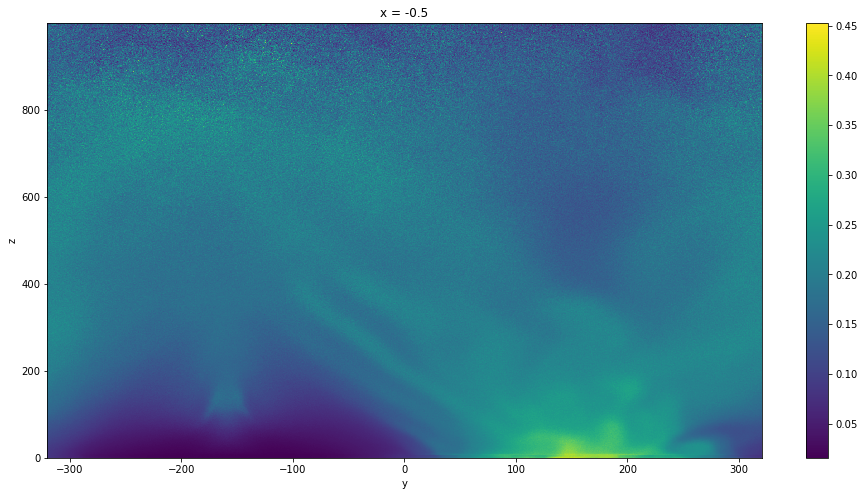

In [5]:
time = -1

h5p = H5Processor(root)


txx = h5p.getH5Grid('txx_e', time, zmin=0, zmax=1000)
tyy = h5p.getH5Grid('tyy_e', time, zmin=0, zmax=1000)
tzz = h5p.getH5Grid('tzz_e', time, zmin=0, zmax=1000)
rho = -h5p.getH5Grid('rho_e', time, zmin=0, zmax=1000)
temp = 1/3*(txx+tyy+tzz)/rho
temp.plot()


1


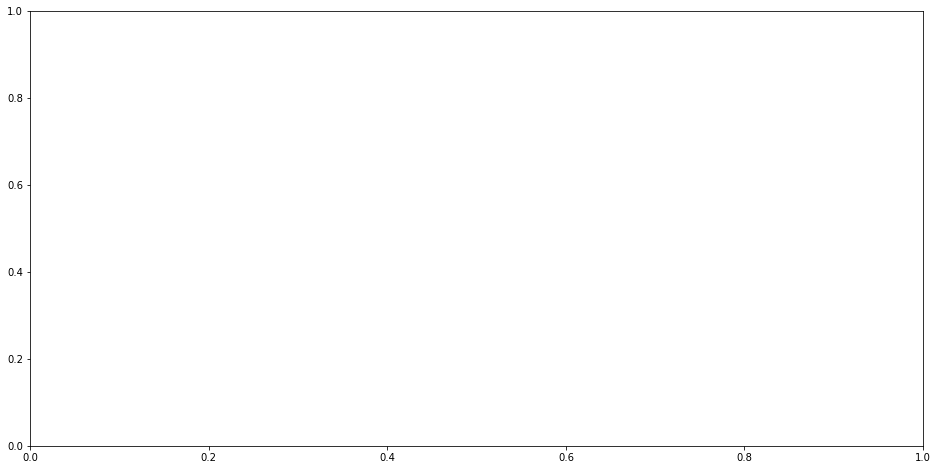

In [14]:
nbins = 100
histograms_e = []
bins_e = []

histograms_he = []
bins_he = []

patches = h5p.getPatches(origin, 5, 5)

patch = patches[0][2]
numPatches = patches[1]
print(numPatches)
cellsPerPatch = 32
for time in range(1000, 5000, 1000):
    path = root + 'checkpoint_' + str(time) + '.bp'
    SC = SuperCell(path, patch, patches=numPatches, species='electron', cellsPerPatch=cellsPerPatch)
    h = SC.histogramV(nbins, dim='s')
    histograms_e.append(h[0])
    bins_e.append(h[1][1:])
    
    SC_he = SuperCell(path, patch, patches=numPatches, species='electron_he', cellsPerPatch=cellsPerPatch)
    h_he = SC_he.histogramV(nbins, dim='s')
    histograms_he.append(h_he[0])
    bins_he.append(h_he[1][1:])


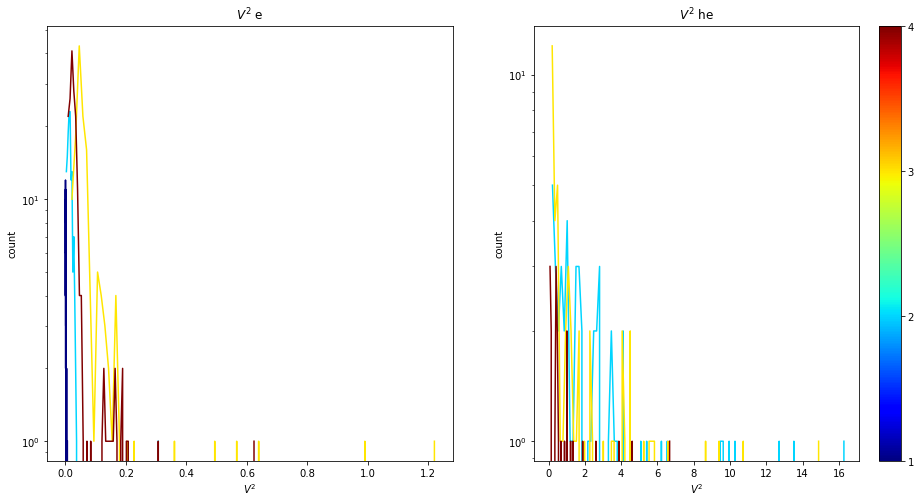

In [15]:
c = np.arange(1, len(histograms_e) + 1)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

fig, axes = plt.subplots(nrows=1, ncols=2)

for i in range(len(histograms_e)):
    axes[0].plot(bins_e[i], histograms_e[i], c=cmap.to_rgba(i + 1))
    axes[1].plot(bins_he[i], histograms_he[i], c=cmap.to_rgba(i + 1))

axes[0].set_title(f'$V^2$ e')
axes[0].set_ylabel('count')
axes[0].set_xlabel('$V^2$')
axes[0].set_yscale('log')
axes[1].set_title(f'$V^2$ he')
axes[1].set_ylabel('count')
axes[1].set_xlabel('$V^2$')
axes[1].set_yscale('log')
#axes[1].set_xlim(0,0.8)
fig.colorbar(cmap, ticks=c)
#plt.savefig(f'hist-t{time}.png')


In [16]:
path = root + 'checkpoint_' + str(1000) + '.bp'
prts = Particles(path)
prts.columns

['grid::n_local',
 'grid::off',
 'grid::xb',
 'grid::xe',
 'mflds',
 'mprts::mprts::kind',
 'mprts::mprts::qni_wni',
 'mprts::mprts::size_by_patch',
 'mprts::mprts::ux',
 'mprts::mprts::uy',
 'mprts::mprts::uz',
 'mprts::mprts::x',
 'mprts::mprts::y',
 'mprts::mprts::z']

In [ ]:
## DON'T RUN UNLESS NECESSARY, TOO SLOW!!!! ##
he_ratios = []
ion_ratios = []
for time in range(1000, 3000,1000):
    path = root + 'checkpoint_' + str(time) + '.bp'
    prts = Particles(path)
    df = []
    for z in range(-zmax+32,zmax-32, 32):
        for y in range(0, ymax-32, 32):
            coord_ = corner + np.array([0, y, z])
            patch_ = prts.getPatchMomentum(coord_, cellsPerPatch)
            df.append(patch_)
    print(time)
    
    residents_ = pd.concat(df, ignore_index=True)
    
    he_ratio = residents_[residents_['kind']==0].shape[0]/(residents_[residents_['kind']==0].shape[0] + residents_[residents_['kind']==1].shape[0])
    he_ratios.append(he_ratio)
    
    ion_ratio = residents_[residents_['kind']==2].shape[0]/(residents_[residents_['kind']==0].shape[0] +
                                                                     residents_[residents_['kind']==1].shape[0])
    ion_ratios.append(ion_ratio)

1000


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(he_ratios)
axes[1].plot(ion_ratios)
axes[0].set_title('he ratio')
axes[1].set_title('ion ratio')
#plt.savefig('species_ratios.png')

Loading rho_he_e from File: tfd_moments.029000.xdmf
(1200, 1920)


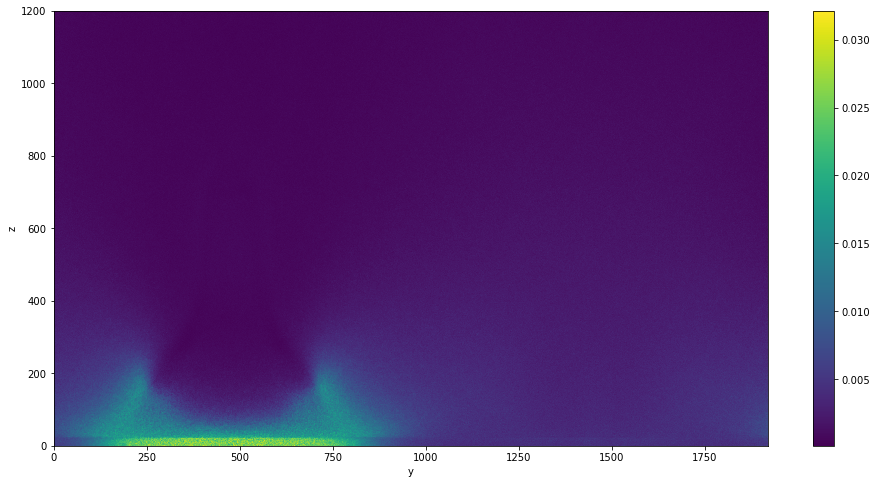

In [15]:
rho_he_e = -getH5Grid(root, 'tfd_moments', 'rho_he_e', -1, corner=corner, dims=globalDims)[:,:,0]
print(rho_he_e.shape)

plt.ylabel('z')
plt.xlabel('y')
plt.pcolormesh(rho_he_e)
plt.colorbar()

Loading jz_ec from File: tfd.029000.xdmf


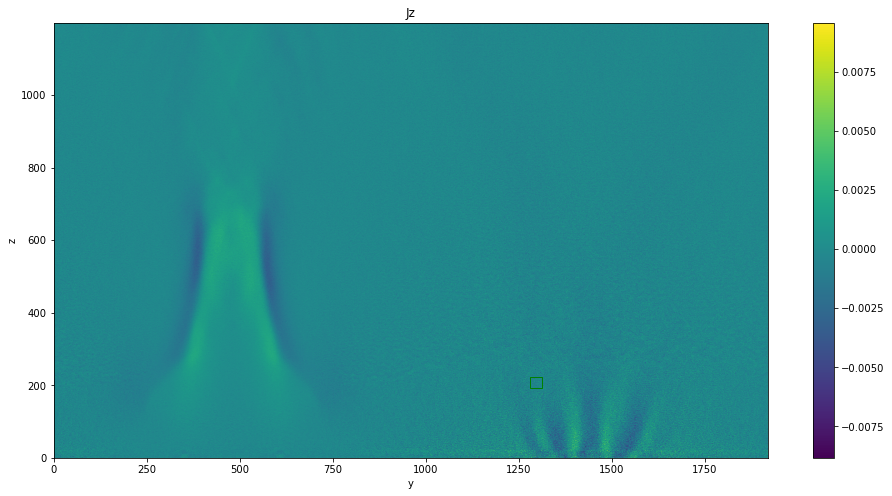

In [16]:
Jz = getH5Grid(root, 'tfd', 'jz_ec', -1, corner=corner, dims=globalDims)[:,:,0]
#Px = getH5Grid(froot, 'tfd_moments', 'px_e', time, corner=corner, dims=globalDims)[0].T
plt.pcolormesh(Jz, shading='gouraud')
plt.colorbar()
plt.title('Jz')
plt.ylabel('z')
plt.xlabel('y')
selectSubSpace(yp, zp, numPatches=numPatches)
#plt.savefig(f'Px-xp-{xp}-yp-{yp}-zp-{zp+320}-t{time}.png')

In [7]:
tt = 0
rho_e1 = -getH5Grid(root, 'tfd_moments', 'rho_e', tt, corner=corner, dims=globalDims)[:,:,0]
rho_he1 = -getH5Grid(root, 'tfd_moments', 'rho_he_e', tt, corner=corner, dims=globalDims)[:,:,0]
Txxe = getH5Grid(root, 'tfd_moments', 'txx_e', tt, corner=corner, dims=globalDims)[:,:,0]
Tyye = getH5Grid(root, 'tfd_moments', 'tyy_e', tt, corner=corner, dims=globalDims)[:,:,0]
Tzze = getH5Grid(root, 'tfd_moments', 'tzz_e', tt, corner=corner, dims=globalDims)[:,:,0]
Txxhe = getH5Grid(root, 'tfd_moments', 'txx_he_e', tt, corner=corner, dims=globalDims)[:,:,0]
Tyyhe = getH5Grid(root, 'tfd_moments', 'tyy_he_e', tt, corner=corner, dims=globalDims)[:,:,0]
Tzzhe = getH5Grid(root, 'tfd_moments', 'tzz_he_e', tt, corner=corner, dims=globalDims)[:,:,0]

tt2 = -1
rho_e2 = -getH5Grid(root, 'tfd_moments', 'rho_e', tt2, corner=corner, dims=globalDims)[:,:,0]
rho_he2 = -getH5Grid(root, 'tfd_moments', 'rho_he_e', tt2, corner=corner, dims=globalDims)[:,:,0]
Txxe2 = getH5Grid(root, 'tfd_moments', 'txx_e', tt2, corner=corner, dims=globalDims)[:,:,0]
Tyye2 = getH5Grid(root, 'tfd_moments', 'tyy_e', tt2, corner=corner, dims=globalDims)[:,:,0]
Tzze2 = getH5Grid(root, 'tfd_moments', 'tzz_e', tt2, corner=corner, dims=globalDims)[:,:,0]
Txxhe2 = getH5Grid(root, 'tfd_moments', 'txx_he_e', tt2, corner=corner, dims=globalDims)[:,:,0]
Tyyhe2 = getH5Grid(root, 'tfd_moments', 'tyy_he_e', tt2, corner=corner, dims=globalDims)[:,:,0]
Tzzhe2 = getH5Grid(root, 'tfd_moments', 'tzz_he_e', tt2, corner=corner, dims=globalDims)[:,:,0]

NameError: name 'getH5Grid' is not defined

<ipython-input-13-5ba56a63fd7b>:3: RuntimeWarning: invalid value encountered in true_divide
  The1 = (Txxhe + Tyyhe + Tzzhe)/(rho_he1)/3


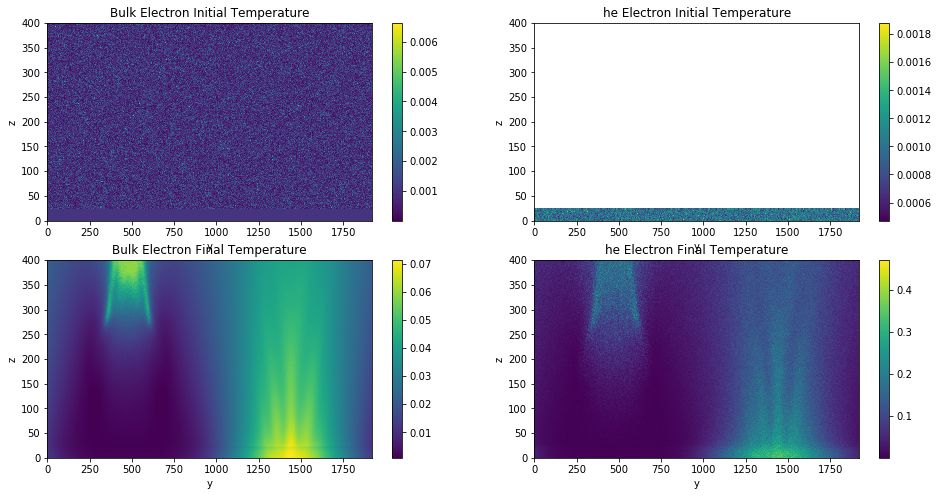

In [13]:
Te1 = (Txxe + Tyye + Tzze)/(rho_e1)/3
Te2 = (Txxe2 + Tyye2 + Tzze2)/(rho_e2)/3
The1 = (Txxhe + Tyyhe + Tzzhe)/(rho_he1)/3
The2 = (Txxhe2 + Tyyhe2 + Tzzhe2)/(rho_he2)/3


fig, axes = plt.subplots(2,2)
pcm1=axes[0,0].pcolormesh(Te1)
pcm2=axes[0,1].pcolormesh(The1)
pcm3=axes[1,0].pcolormesh(Te2)
pcm4=axes[1,1].pcolormesh(The2)
axes[0,0].set_title('Bulk Electron Initial Temperature')
axes[1,0].set_title('Bulk Electron Final Temperature')
axes[0,1].set_title('he Electron Initial Temperature')
axes[1,1].set_title('he Electron Final Temperature')
fig.colorbar(pcm1, ax=axes[0,0])
fig.colorbar(pcm2, ax=axes[0,1])
fig.colorbar(pcm3, ax=axes[1,0])
fig.colorbar(pcm4, ax=axes[1,1])

for i in range(2):
    for j in range(2):
        axes[i,j].set_ylim(0,400)
        axes[i,j].set_ylabel('z')
        axes[i,j].set_xlabel('y')
#plt.savefig('bulk-temp.png')

Text(0.5, 0, 'y')

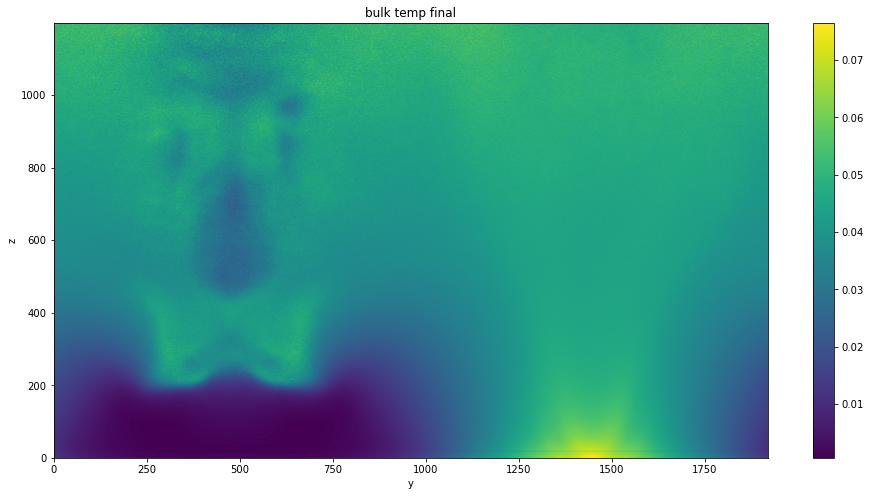

In [17]:
plt.pcolormesh(Te2, shading='gouraud')
plt.colorbar()
plt.title('bulk temp final')
plt.ylabel('z')
plt.xlabel('y')
#plt.clim(0,0.5)

NameError: name 'getH5Grid' is not defined

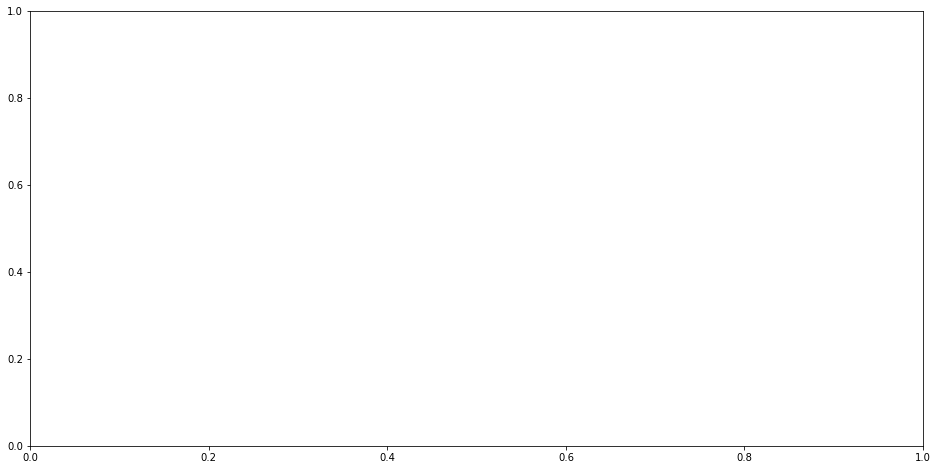

In [4]:

nr, nc = 3, 3
c2 = np.arange(1, nr*nc + 1)
norm2 = matplotlib.colors.Normalize(vmin=c2.min(), vmax=c2.max())
cmap2 = matplotlib.cm.ScalarMappable(norm=norm2, cmap=matplotlib.cm.jet)
cmap2.set_array([])


fig, axes = plt.subplots(nrows=1, ncols=1)
bx = getH5Grid(root, 'tfd', 'hx_fc', -1, corner=corner, dims=globalDims)[:,:,0]
mesh = axes.pcolormesh( bx , cmap='bwr')

axes.set_title(f'Bx')
axes.set_ylabel('z')
axes.set_xlabel('y')
fig.colorbar(mesh, ax=axes)

for i in range(nr):
    for j in range(nc):
        ## yp,j = cols, zp,i = rows
        yp, zp = 224 + 256*j, 192 + 192*i #832
        
        rect = matplotlib.patches.Rectangle((yp,zp), cellsPerPatch*numPatches, cellsPerPatch*numPatches, linewidth=1, edgecolor=cmap2.to_rgba(i*nc +j + 1),facecolor='none')
        axes.add_patch(rect)

plt.tight_layout()



/gpfs/alpine/proj-shared/fus137/johnd/flatfoil-summit_10-29/run2Dratio01TripleNI1000/checkpoint_29000.bp


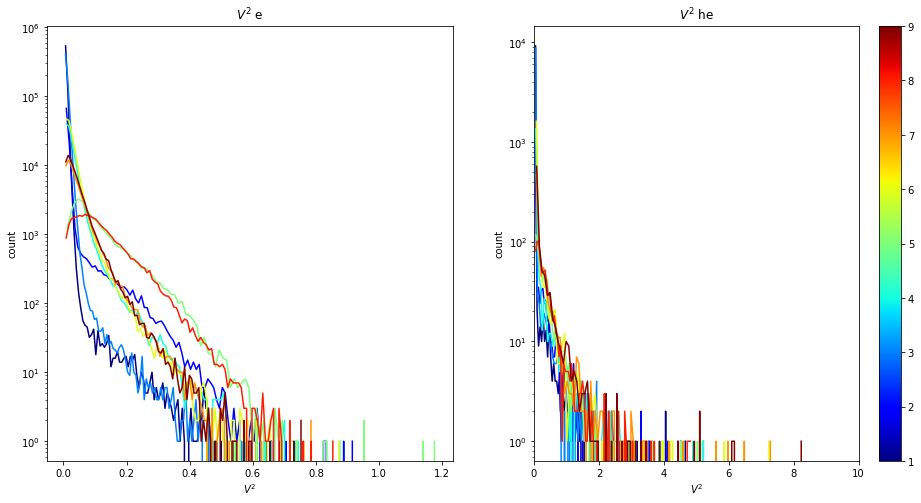

In [25]:
scan_histograms_e = []
scan_bins_e = []
scan_histograms_he = []
scan_bins_he = []
nbins = 100
path = root + 'checkpoint_' + str(29000) + '.bp'
print(path)
for i in range(nr):
    for j in range(nc):
        yp, zp = 224 + 256*j, 192 + 192*i
        patch = np.array(corner) + np.array((xp, yp, zp))
        SC = SuperCell(path, patch, patches=numPatches, species='electron', cellsPerPatch=cellsPerPatch)
        h = SC.histogramV(nbins, log=True, dim='s')
        scan_histograms_e.append(h[0])
        scan_bins_e.append(h[1][1:])

        SC_he = SuperCell(path, patch, patches=numPatches, species='electron_he', cellsPerPatch=cellsPerPatch)
        h_he = SC_he.histogramV(nbins, log=True, dim='s')
        scan_histograms_he.append(h_he[0])
        scan_bins_he.append(h_he[1][1:])
        
fig, axes = plt.subplots(nrows=1, ncols=2)

for i in range(len(scan_histograms_e)):
    axes[0].plot(scan_bins_e[i], scan_histograms_e[i], c=cmap2.to_rgba(i + 1))
    axes[1].plot(scan_bins_he[i], scan_histograms_he[i], c=cmap2.to_rgba(i + 1))

axes[0].set_title(f'$V^2$ e')
axes[0].set_ylabel('count')
axes[0].set_xlabel('$V^2$')
axes[0].set_yscale('log')
axes[1].set_title(f'$V^2$ he')
axes[1].set_ylabel('count')
axes[1].set_xlabel('$V^2$')
axes[1].set_yscale('log')
#axes[0].set_xlim(0,0.5)
axes[1].set_xlim(0,10)
fig.colorbar(cmap2, ticks=c2)


Temperature moment from histogram:  0.02954836757011527


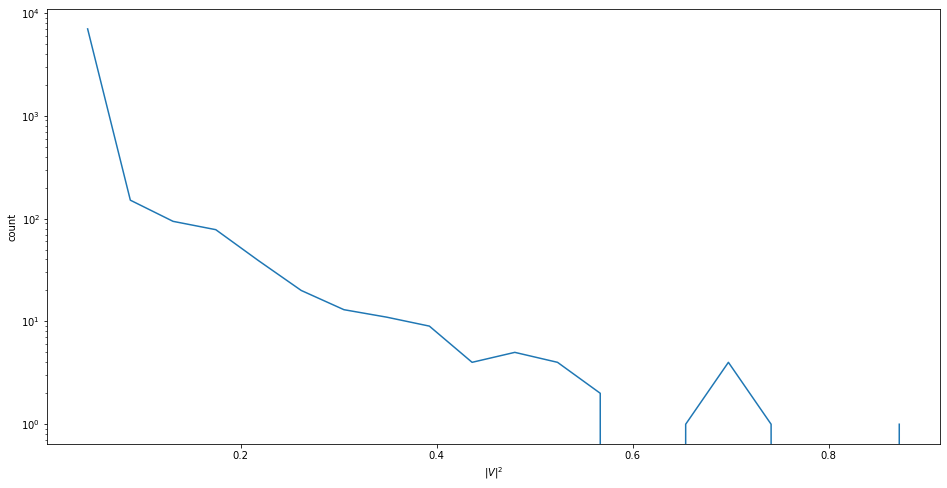

In [11]:
tcheck = str(29000)
ini, inj = 1, 1
path = root + 'checkpoint_' + tcheck + '.bp'
xp, yp, zp = 0, 224 + 256*inj, 192 + 192*ini
corner = (0, 0, 1920)
patch = np.array(corner) + np.array((xp, yp, zp))
numPatches=2
cellsPerPatch=32
nbins=20
SCin = SuperCell(path, patch, patches=numPatches, species='electron', cellsPerPatch=cellsPerPatch)
hin = SCin.histogramV(nbins, dim='s')
plt.plot(hin[1][1:], hin[0])
plt.ylabel('count')
plt.xlabel('$|V|^2$')
plt.yscale('log')
binsCenter = 0.5*(hin[1][1:] + hin[1][:-1])
Tmom = np.sum(binsCenter*hin[0])/np.sum(hin[0])
print("Temperature moment from histogram: ", Tmom)
SCin.residents.to_csv('toy_data.csv', index=False)

Estimated Temp from Fit red:  0.041536996486098834


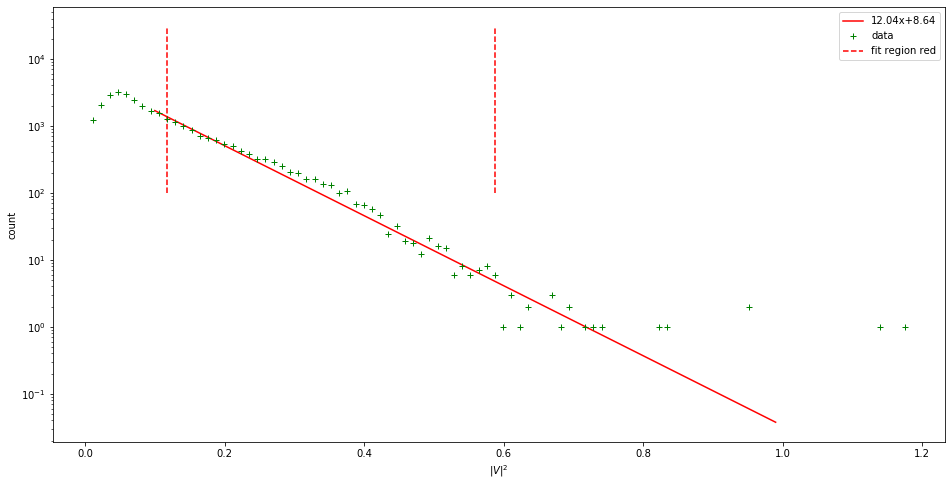

In [31]:
## Fit
from scipy.optimize import curve_fit

def logarithmic_line(x, m, b):
    return np.exp(b)*np.exp(-x*m)
    
#hh = h[1]**0.5*np.exp(-h[1]/(0.8*TxxMean*2))*2e4
#hh = h[1]**0.5*np.exp(-h[1]/(0.006*2))*2.5e4
#plt.plot(h[1], hh, '-m',label='fake maxwellian' )
def straight_line(x, m, b):
    return -m*x+b

l1, r1 = 10, 50
l2, r2 = 30, 35
popt1, pcov1 = curve_fit( straight_line, hin[1][ l1  : r1], np.log(hin[0][l1 : r1] + 1e-5) )
popt2, pcov2 = curve_fit( straight_line, hin[1][ l2  : r2], np.log(hin[0][l2 : r2] + 1e-1) )


dummyline = np.arange(0.1,1,0.01)
dummyline2 = np.arange(10, 15, 0.01)
plt.plot(dummyline, logarithmic_line(dummyline, *popt1), '-r', label=f'{popt1[0]:.2f}x+{popt1[1]:.2f}')
#plt.plot(dummyline2, logarithmic_line(dummyline2, *popt2), '-b', label=f'{popt2[0]:.2f}x+{popt2[1]:.2f}')

plt.plot(hin[1][1:],hin[0], '+g', label='data')
plt.vlines((hin[1][l1],hin[1][r1]), ymin=1e2, ymax=3e4, color='r', linestyles='dashed', label='fit region red')
#plt.vlines((hin[1][l2],hin[1][r2]), ymin=1e0, ymax=3e2, color='b', linestyles='dashed', label='fit region blue')
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('$|V|^2$')
plt.title(f'')
plt.legend()
#plt.xlim(0,1.2)
#plt.savefig(f'Maxwellian-xp-{xp}-yp-{yp}-zp-{zp+320}-t{tcheck}.png')
print("Estimated Temp from Fit red: ", 1/popt1[0]/2)
#print("Estimated Temp from Fit blue: ", 1/popt2[0]/2)


In [54]:
hin[0][l2 : r2]

array([3, 8, 4, 2, 4, 2, 5, 5, 1, 2, 2, 2, 0, 1, 1, 5, 3, 2, 0, 3])

In [60]:
tt3=-1
px = getH5Grid(root, 'tfd_moments', 'px_e', tt3, corner=corner, dims=globalDims)[:,:,0]
py = getH5Grid(root, 'tfd_moments', 'py_e', tt3, corner=corner, dims=globalDims)[:,:,0]
pz = getH5Grid(root, 'tfd_moments', 'pz_e', tt3, corner=corner, dims=globalDims)[:,:,0]
momentas = [px, py, pz]

Loading px_e from File: tfd_moments.029000.xdmf
Loading py_e from File: tfd_moments.029000.xdmf
Loading pz_e from File: tfd_moments.029000.xdmf


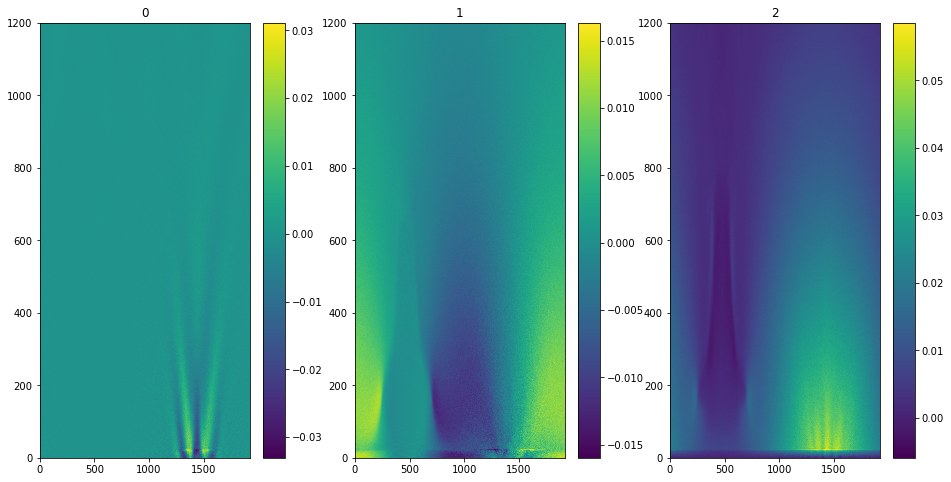

In [61]:
fig, axes = plt.subplots(1, 3)
for idx, ax in enumerate(axes):
    pcm = ax.pcolormesh(momentas[idx])
    fig.colorbar(pcm, ax=axes[idx])
    ax.set_title(idx)

In [4]:
path = root + 'checkpoint_' + str(29000) + '.bp'
prts = Particles(path)

kindMap = {'he':0, 'e':1, 'i':2}
for threshold in [0.5]:#1, 2, 3, 4, 5, 6, 7]:
    n = []
    for z in range(zmax//4-32, 0, -32):
        n_y = []
        for y in range(0, ymax, 32):
            coord_ = corner + np.array([0, y, z])
            patch_ = prts.getPatchMomentum(coord_, cellsPerPatch)
            Vsqr = patch_['ux']**2 + patch_['uy']**2 + patch_['uz']**2 
            mask = np.logical_and(Vsqr >= threshold, patch_['kind'] == kindMap['he'])
            n_y.append(patch_[mask].shape[0])
        n.append(n_y)
    #n = np.array(n)
    ax = sns.heatmap(n)
    #plt.savefig(f'threshold-{threshold}.png')
    #plt.close()

RuntimeError: ERROR: couldn't read from file /gpfs/alpine/proj-shared/fus137/johnd/flatfoil-summit_10-29/run2Dratio01TripleNI1000/checkpoint_29000.bp/data.87, in call to POSIX IO read
: iostream error